In [1]:
from scoresbibm.utils.data_utils import query, get_summary_df, load_model
from scoresbibm.utils.plot import plot_metric_by_num_simulations, use_style,multi_plot

from scoresbibm.src.tasks import get_task

import matplotlib.pyplot as plt
from functools import partial

import jax 
import jax.numpy as jnp
import numpy as np

/mnt/qb/work/macke/mgloeckler90/miniconda3/envs/probjax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
jax.devices()

[cuda(id=0)]

In [3]:
PATH = "../../../../results/main_benchmark_additional"

In [4]:
df = query(PATH, method="score_transformer", metric="nll_posterior", task="slcp")
df

,method,task,num_simulations,seed,model_id,metric,value,time_train,time_eval,cfg
88,score_transformer,slcp,1000,0,28,nll_posterior,6.097095,109.800846,NaN,"{'name': 'main_benchmark_additional', 'seed': ..."
96,score_transformer,slcp,100000,0,30,nll_posterior,2.180182,1203.692338,NaN,"{'name': 'main_benchmark_additional', 'seed': ..."
116,score_transformer,slcp,10000,0,35,nll_posterior,2.983918,528.489840,NaN,"{'name': 'main_benchmark_additional', 'seed': ..."


In [11]:
model = load_model(PATH, 30)

In [13]:
task = get_task("slcp")
data = task.get_data(1000, rng=jax.random.PRNGKey(0))

thetas, xs = data["theta"], data["x"]
condition_mask = np.array([False] * task.get_theta_dim() + [True] * task.get_x_dim())

In [19]:
@partial(jax.jit, static_argnums=0)
def log_prob_fn(num_steps):
    return model.log_prob_batched(thetas, xs, num_steps=num_steps, condition_mask=condition_mask, method="rk4").mean()

In [28]:
steps_to_eval = [5, 10, 25,50, 100, 250, 500]
values = [log_prob_fn(num_steps) for num_steps in steps_to_eval] # Computes values and compiles 

In [29]:
import time

In [30]:
times = []
for num_steps in steps_to_eval:
    avg_runtime = 0
    for _ in range(3):
        start_time = time.time()
        log_prob = log_prob_fn(num_steps)
        avg_runtime += time.time() - start_time
    times.append(avg_runtime / 3)
    

In [47]:
@partial(jax.jit, static_argnums=0)
def log_prob_fn_likelihood(num_steps):
    return model.log_prob_batched(xs, thetas, num_steps=num_steps, condition_mask=~condition_mask, method="rk4").mean()

In [48]:
values_likelihood = [log_prob_fn_likelihood(num_steps) for num_steps in steps_to_eval] # Computes values and compiles

In [49]:
times_likelihood = []
for num_steps in steps_to_eval:
    avg_runtime = 0
    for _ in range(3):
        start_time = time.time()
        log_prob = log_prob_fn_likelihood(num_steps)
        avg_runtime += time.time() - start_time
    times_likelihood.append(avg_runtime / 3)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

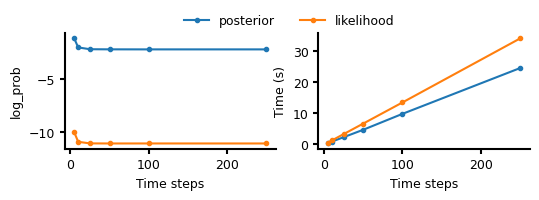

In [58]:
with use_style("pyloric"):
    fig, ax = plt.subplots(1,2, figsize=(6, 1.5))
    ax[0].plot(steps_to_eval[:-1], values[:-1], marker="o")
    ax[0].plot(steps_to_eval[:-1], values_likelihood[:-1], marker="o")

    ax[0].set_xlabel("Time steps")
    ax[0].set_ylabel("log_prob")
    ax[1].plot(steps_to_eval[:-1], times[:-1], marker="o")
    ax[1].plot(steps_to_eval[:-1], times_likelihood[:-1], marker="o")
    
    ax[1].set_xlabel("Time steps")
    ax[1].set_ylabel("Time (s)")
    fig.legend(["posterior", "likelihood"], loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.08))
    fig.savefig("log_prob_time_steps.svg", bbox_inches="tight")
    fig.savefig("log_prob_time_steps.png", bbox_inches="tight")
    plt.show()
    

In [10]:

condition_mask_posterior = np.array([False, False, True, True])
condition_mask_missing_data_posterior = np.array([False, False, True, False])
condition_mask_missing_data_posterior2 = np.array([False, False, False, True])
condition_mask_likelihood = np.array([True, True, False, False])
condition_mask_mixed = np.array([True, False, False, True])
observation_posterior = jnp.array([0., 0.])